**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.neighbors import KDTree
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer


from scipy import spatial

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        
    def fit(self, X, y):
        if self.algorithm == 'brute':
            if (type(X) != np.ndarray):
                self.x_train = X.toarray()
            else:
                self.x_train = X
            self.x_train = (self.x_train - np.mean(self.x_train, axis = 0)) / np.std(self.x_train, axis = 0)
            
        elif self.algorithm == 'kd_tree':
            if (type(X) != np.ndarray):
                self.x_train_tree = X.toarray()
            else:
                self.x_train_tree = X
            self.x_train_tree = KDTree((X - np.mean(X, axis = 0)) / np.std(X, axis = 0))
        self.y_train = y
        
    def predict(self, X):
        if (type(X) != np.ndarray):
            self.x_test = X.toarray()
        else:
            self.x_test = X
        self.x_test = (self.x_test - np.mean(self.x_test, axis = 0)) / np.std(self.x_test, axis = 0)
        
        if self.algorithm == 'brute':
            distant = pairwise_distances(self.x_test, self.x_train, metric = self.metric)
            
            distant =  np.argpartition(distant, self.n_neighbors, axis=1)
            
            priznaki = self.y_train[distant][:, 0:self.n_neighbors]
            
        elif self.algorithm == 'kd_tree':
            
            distant, indices = self.x_train_tree.query(self.x_test, self.n_neighbors)
            
            priznaki = self.y_train[indices]
        
        indices = np.unique(priznaki, return_inverse=True)
        
        return indices[0][np.argmax(np.apply_along_axis(np.bincount, 1, priznaki, None, np.max(indices[1]) + 1), axis=1)]
            

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, 'Score must be equal'

In [8]:
counter_better = 0
counter_equal = 0
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
    my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    
    if accuracy_score(y_test, my_clf_pred) >  accuracy_score(y_test, sklearn_pred ):
        counter_better += 1
    elif accuracy_score(y_test, my_clf_pred) == accuracy_score(y_test, sklearn_pred ):
        counter_equal += 1
print(counter_better, 'better', counter_equal, 'equal', 1000, 'all')

190 better 585 equal 1000 all


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 655 µs, sys: 133 µs, total: 788 µs
Wall time: 698 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 472 µs, sys: 262 µs, total: 734 µs
Wall time: 545 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 2.25 ms, sys: 646 µs, total: 2.9 ms
Wall time: 2.37 ms


array([1, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 0, 2, 0])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 1.09 ms, sys: 293 µs, total: 1.38 ms
Wall time: 1.19 ms


array([1, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 0, 2, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 860 µs, sys: 184 µs, total: 1.04 ms
Wall time: 932 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 925 µs, sys: 991 µs, total: 1.92 ms
Wall time: 1.79 ms


In [17]:
%time clf.predict(X_test)

CPU times: user 2.7 ms, sys: 1.2 ms, total: 3.9 ms
Wall time: 3.1 ms


array([2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 1.06 ms, sys: 535 µs, total: 1.6 ms
Wall time: 1.21 ms


array([2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0])

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [20]:
counter_better = 0
counter_equal = 0
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
    my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    if accuracy_score(y_test, my_clf_pred) >  accuracy_score(y_test, sklearn_pred ):
        counter_better += 1
    elif accuracy_score(y_test, my_clf_pred) == accuracy_score(y_test, sklearn_pred ):
        counter_equal += 1
print(counter_better, 'better', counter_equal, 'equal')

202 better 584 equal


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [21]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [22]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [23]:
vectorize = CountVectorizer(data, min_df = 0.005)
vectorizer = TfidfVectorizer(data, min_df = 0.005)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
matrix_tfidf = vectorizer.fit_transform(data)
matrix = vectorize.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [25]:
rkf = KFold(n_splits=3)
test = rkf.split(matrix)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [26]:
def calculate_optimal(X, y, alg='brute', metr='euclidean'):
    scores = np.array(range(19), dtype=float)
    for n in range(1, 20):
        rkf = KFold(n_splits=3, shuffle = True)
        test = rkf.split(X)
        my_clf = MyKNeighborsClassifier(n_neighbors=n+1, algorithm=alg, metric=metr)
        curr_result = []
        for training, testing in test:
            training_X, training_Y = X[training], y[training]
            testing_X, testing_Y = X[testing], y[testing]
            my_clf.fit(training_X, training_Y)
            my_clf_pred = my_clf.predict(testing_X)
            curr_result.append(accuracy_score(testing_Y, my_clf_pred))
        scores[n-1] = np.mean(curr_result)
    return scores

In [27]:
brute_eucl_count = calculate_optimal(matrix, target, alg = 'brute', metr = 'euclidean')
brute_eucl_count

array([0.1993987 , 0.19957663, 0.20152015, 0.20346587, 0.21194964,
       0.21009452, 0.21796036, 0.21654444, 0.21415977, 0.20496782,
       0.20470123, 0.20425909, 0.20797349, 0.19462491, 0.19939879,
       0.19630477, 0.19126904, 0.19453912, 0.19153108])

In [28]:
brute_cosine_count = calculate_optimal(matrix, target, alg = 'brute', metr = 'cosine')
brute_cosine_count

array([0.29626949, 0.30678784, 0.32349314, 0.33957933, 0.34426348,
       0.3515102 , 0.35486976, 0.36185323, 0.36070387, 0.36202938,
       0.3645932 , 0.37343086, 0.37334185, 0.37387315, 0.38333013,
       0.38120807, 0.38518701, 0.38916417, 0.38147428])

In [29]:
brute_eucl_tfidf = calculate_optimal(matrix_tfidf, target, alg = 'brute', metr = 'euclidean')
brute_eucl_tfidf

array([0.09828509, 0.10562108, 0.10677016, 0.10173285, 0.09192148,
       0.08971213, 0.08538095, 0.09121424, 0.08953464, 0.08608758,
       0.08538083, 0.08051912, 0.08113853, 0.0773375 , 0.07919307,
       0.07716078, 0.07397898, 0.07901764, 0.07530463])

In [30]:
new_brute_cosine_tfidf = calculate_optimal(matrix_tfidf, target, alg = 'brute', metr = 'cosine')
new_brute_cosine_tfidf

array([0.34620891, 0.36388483, 0.38695385, 0.40162633, 0.41841901,
       0.42328062, 0.43335764, 0.43795265, 0.44634864, 0.45324395,
       0.46438017, 0.46535288, 0.4733068 , 0.47613539, 0.47595932,
       0.47940678, 0.48064343, 0.48506202, 0.49337086])

Text(0.5, 0, 'number of neighbors')

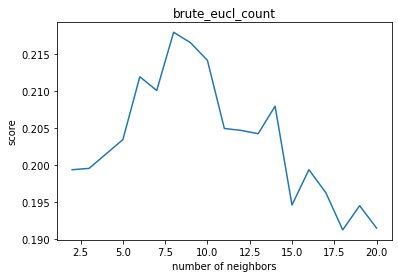

In [31]:
plt.plot(np.arange(2, 21, 1), brute_eucl_count)
plt.title('brute_eucl_count')
plt.ylabel('score')
plt.xlabel('number of neighbors')

Text(0.5, 0, 'number of neighbors')

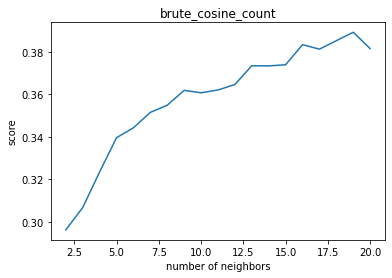

In [33]:
plt.plot(np.arange(2, 21, 1), brute_cosine_count)
plt.title('brute_cosine_count')
plt.ylabel('score')
plt.xlabel('number of neighbors')

Text(0.5, 0, 'number of neighbors')

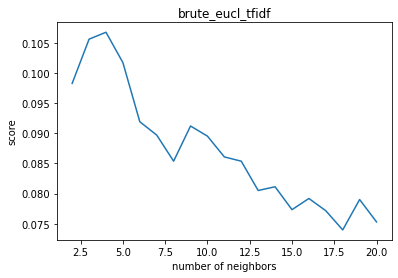

In [34]:
plt.plot(np.arange(2,21,1), brute_eucl_tfidf)
plt.title('brute_eucl_tfidf')
plt.ylabel('score')
plt.xlabel('number of neighbors')

Text(0.5, 0, 'number of neighbors')

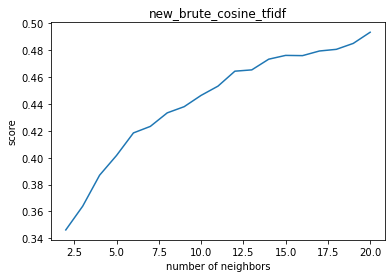

In [35]:
x = np.arange(2, 21, 1)
plt.plot(x, new_brute_cosine_tfidf)
plt.title('new_brute_cosine_tfidf')
plt.ylabel('score')
plt.xlabel('number of neighbors')

In [36]:
i = [130,150,170]
scores = np.array(range(len(i)), dtype=float)
k = 0
for n in i:
    print(n, 'iteration')
    rkf = KFold(n_splits=3, shuffle = True)
    test = rkf.split(matrix_tfidf)
    test_clf = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute', metric='cosine')
    curr_result = []
    for training, testing in test:
        training_X, training_Y = matrix_tfidf[training], target[training]
        testing_X, testing_Y = matrix_tfidf[testing], target[testing]
        test_clf.fit(training_X, training_Y)
        test_clf_pred = test_clf.predict(testing_X)
        curr_result.append(accuracy_score(testing_Y, test_clf_pred))
        print(accuracy_score(testing_Y, test_clf_pred), ' number of neighbours -', n)
    scores[k] = np.mean(curr_result)
    k += 1

130 iteration
0.5861611876988335  number of neighbours - 130
0.5762397242110846  number of neighbours - 130
0.5632458233890215  number of neighbours - 130
150 iteration
0.5914634146341463  number of neighbours - 150
0.5693450013259083  number of neighbours - 150
0.5682842747281888  number of neighbours - 150
170 iteration
0.5763520678685048  number of neighbours - 170
0.5855210819411297  number of neighbours - 170
0.5823389021479713  number of neighbours - 170


Text(0.5, 0, 'number of neighbors')

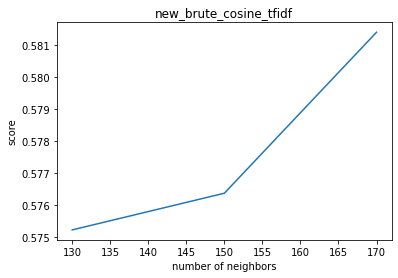

In [37]:
plt.plot(i, scores)
plt.title('new_brute_cosine_tfidf')
plt.ylabel('score')
plt.xlabel('number of neighbors')

Чем больше соседей - тем значение лучше, возьмем 170.

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [38]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [39]:
new_data = newsgroups_test['data']
new_target = newsgroups_test['target']

In [40]:
vectorizer_test = TfidfVectorizer(new_data, min_df = 0.005)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
matrix_test_tfidf = vectorizer_test.fit_transform(new_data)

In [44]:
rkf = KFold(n_splits=3, shuffle = True)
test = rkf.split(matrix_test_tfidf)
my_clf = MyKNeighborsClassifier(n_neighbors=170, algorithm='brute', metric='cosine')
curr_result = []
for training, testing in test:
    training_X, training_Y = matrix_test_tfidf[training], new_target[training]
    testing_X, testing_Y = matrix_test_tfidf[testing], new_target[testing]
    my_clf.fit(training_X, training_Y)
    my_clf_pred = my_clf.predict(testing_X)
    curr_result.append(accuracy_score(testing_Y, my_clf_pred))
    print(accuracy_score(testing_Y, my_clf_pred), ' number of neighbours -', 170)

0.577857427319793  number of neighbours - 170
0.5483870967741935  number of neighbours - 170
0.5621513944223108  number of neighbours - 170


Ненамного отличается. Может быть различным, так как разные слова в разных словарях, разная частотность вхождения.